# Segmentierung von Bildern

In diesem Notebook wird vorgeführt, wie Sie Ihren Kreuz-Kreis-Plus-Datensatz aus einem Foto von handgezeichneten Symbolen erstellen können. Die Gruppierung von Pixeln nennt sich Bildsegmentierung und ist letztlich ein "unüberwachtes" Lernproblem. Wird sie gut gemacht, so können in vielen Anwendungen nachgelagerte Aufgaben viel einfacher gelöst werden. 

Hier wird das Package scikit-image benutzt aber es wird ein kleiner Teil der darin enthaltenen Bildsegmentierungsverfahren vorgeführt. Nutzen Sie die  Gelegenheit, sich über das Gebiet der Bildsegmentierung und den diesbezüglichen Funktionsumfang von scikit-image zu informieren. Die hier benutzten Algorithmen (zur Schwellwertfindung und Segmentierung) sind teilweise alles andere als einfach, aber eben bereits in Standard Open-Source Software verfügbar und online gut dokumentiert.  

**Beachten Sie:** Segmentierung ist ein anspruchsvolles Ziel und nicht nur in der Forschung weites und Gebiet. Sobald die zu segmentierenden Objekte z.B. 
- weniger klare Konturen haben,
- weniger kontrastreich sind,
- unterschiedlich beleuchtet werden,
- aus unterschiedlichen Winkeln fotografiert wurden,
- mehr Rauschen besitzen, oder 
- von anderen Objekten überdeckt werden,
wird die Aufgabe deutlich schwieriger. Diese Übung hier liefert Ihnen nur einen Einstieg.



Angepasst von  
http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html  
Dr. B.Tödtli, Fernfachhochschule Schweiz (FFHS)

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import skimage.data

plt.rcParams['image.cmap'] = 'gray'

def remove_ticks(x=True,y=True):
    if x: plt.gca().axes.get_xaxis().set_visible(False)
    if y: plt.gca().axes.get_yaxis().set_visible(False)
        
def show_images(imglist,figsize=(15,15),**kwargs):
    """
    Erstelle aus einer Liste von Pixel-Arrays eine Visualisierung 
    der dazugehörigen Bilder, für den praktischen visuellen Vergleich.
    """
    nImages=len(imglist)
    plt.figure(figsize=figsize)
    for i,image in enumerate(imglist):
        plt.subplot(1,nImages,i+1)
        plt.imshow(image,**kwargs);
        remove_ticks()

**Aufgabe** 
Lesen Sie hier mit Hilfe der Funktion skimage.data.imread Ihr Bild als Graustufenbild ein

In [0]:
im=skimage.data.imread('https://raw.githubusercontent.com/sakuronohana/cas_datenanalyse/master/PVA2/Segment_pics/IMG_7919.JPG')

((2448, 3264, 3), 0, 255)

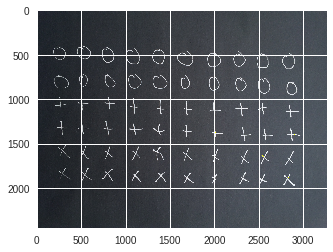

In [15]:
#Die InputDatei ist einfach ein Foto einer Weissen Fläche, mit den 'x','o','p'-Symbolen
#nebeneinander gemalt.

#Bei hellem Papier und dunklem Stift muss das Bild invertiert werden:
image=1-im

plt.imshow(image)
image.shape,image.min(),image.max()

In [0]:
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from skimage.color import rgb2gray

** Aufgabe:** Bestimmen Sie hier einen Schwellwert, so dass das Bild binär wird.

    thresh = Ihre_Schwellwertfunktion(image) 
    #oder
    thresh = <eine Zahl>
    
Wenden Sie falls sinnvoll anschliessend noch ein morphologisches closing an. Macht dies bei Ihrem Datensatz einen Unterschied?
Speichern Sie Ihren Output in der Variablen 
    
    bw  
Die Idee davon ist, dünne Linien zu schliessen.   

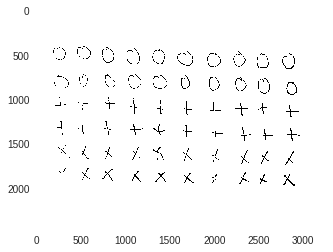

In [17]:
image = rgb2gray(image)

#with threshold_otsu
thresh = threshold_otsu(image)
bw = image <= thresh


plt.imshow(bw)

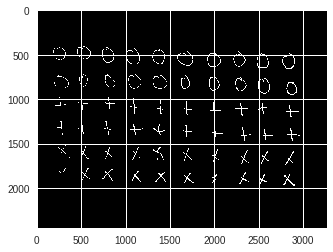

In [18]:
image = rgb2gray(image)

# with closing
thresh = threshold_otsu(image)
bw = closing(image > thresh, square(3))

plt.imshow(bw)

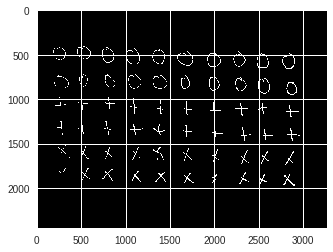

In [19]:
# remove artifacts connected to image border
#clear_border?
cleared = clear_border(bw)
plt.imshow(cleared);

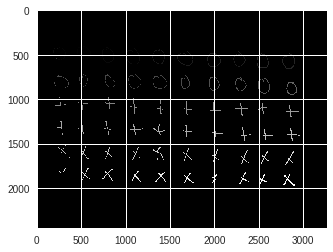

In [20]:
# label ist der Segmentierungsbefehl
#label?
label_image = label(cleared)
#label_image enthält integers, welche das label des Segments enthält. 
plt.imshow(label_image);
#Die Zeichen scheinen von oben nach unten durchnummeriert zu werden:

(0, 85, (2448, 3264, 3))

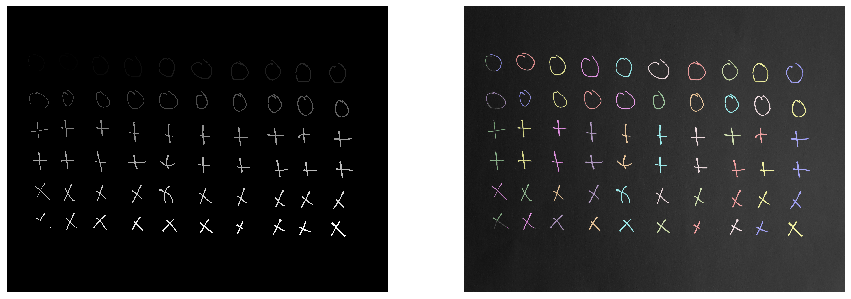

In [21]:
#Mache diese Labelzuordnung noch etwas deutlicher:
#label2rgb? 
image_label_overlay = label2rgb(label_image, image=image,bg_label=0)
show_images([label_image,image_label_overlay]);
label_image.min(),label_image.max(),image_label_overlay.shape

die Segmente sind nun von (0 bis 83) durchnummeriert. Das Hintergrundsegment ist 0.

(1795, (1839, 1965, 1948, 2026), 81)

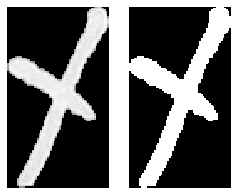

In [22]:
#regionprops?
regionlist=regionprops(label_image,image,cache=True)
#Untersuchen wir eine Region:
testregion=regionlist[80]

show_images([testregion.intensity_image,testregion.image],figsize=(4,4),interpolation='none')
testregion.area,testregion.bbox,testregion.label

Es gibt noch viele weitere Eigenschaften dieser Segmente! Siehe 

    help(regionprops)

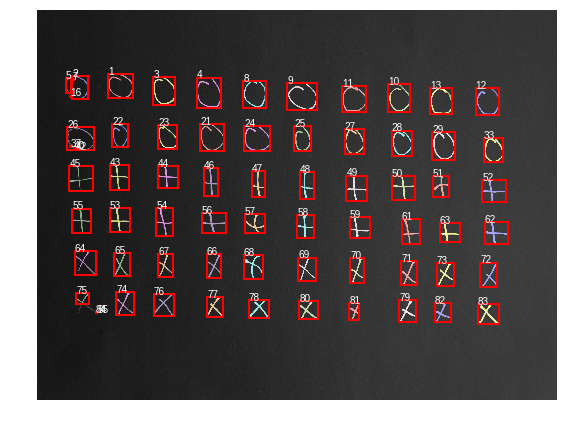

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)
bboxw=60
Kreuz_Kreis_Plus_images=[]
Kreuz_Kreis_Plus_labels=[]
for region in regionprops(label_image,image):
    # Allzu kleine Regionen lassen wir weg:
    if region.area <10: continue
    # Zeichne ein Rechteck um die Region
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False,  edgecolor='red',linewidth=2)
    plt.text(minc, minr,region.label,color='w')
    ax.add_patch(rect)
    
    Kreuz_Kreis_Plus_images.append(region.intensity_image)
    Kreuz_Kreis_Plus_labels.append(region.label)
    

ax.set_axis_off()
plt.tight_layout()
plt.show()

**Aufgabe:** 
Erstellen Sie nun den Zielvektor

    oxp_labels = ['o','o','x','p','p',...]
    
nicht alle Labels werden richtig vergeben (bei mir fehlte das Label 43). Entfernen Sie solche Bilder und erstellen Sie sorgfältig ihren Labelvektor

In [0]:
#Ich sehe das Label 43 nirgends...?

dig = 70
for dig in range(len(regionlist)):
 
  #print(regionprops(label_image,image)[dig].label)
  show_images([regionprops(label_image,image)[dig].intensity_image,
             regionprops(label_image,image)[dig].image],figsize=(5,5))
  #Hmmm...

skip_image_labels=[6,7,14,15,16,17,18,19,20,29,30,31,34,35,36,37,38,39,40,41,42,84,85]   # Aufgabe: Passen Sie diese Zeile an!

In [25]:
#lese an obigem Bild das Label ab:
#print(Kreuz_Kreis_Plus_labels)
print('Anzahl Bilder = ',np.count_nonzero(Kreuz_Kreis_Plus_labels))
oxp_labels= ['o']*23+['p']*23+['x']*22 
# print(oxp_labels)
print('Anzahl Labels = ',np.count_nonzero(oxp_labels))
assert len(Kreuz_Kreis_Plus_images)==len(oxp_labels),'Anzahl Labels sollten gleich sein wie die Anzahl Bilder...'
len(oxp_labels)==(len(regionprops(label_image,image))-1)

Anzahl Bilder =  68
Anzahl Labels =  68


False

['o', 'p', 'p', 'p', 'p', 'x']


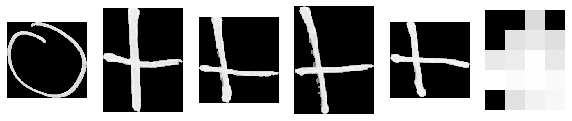

In [26]:
indices=[0,41,42,43,44,-1]
print([oxp_labels[ind] for ind in indices])
show_images([Kreuz_Kreis_Plus_images[i] for i in indices],figsize=(10,10))

In [0]:
def padRows(image,DeltaRows):
    """
    Füge dem <image> <DeltaRows> Zeilen (mit Wert 0) hinzu (symmetrisch oben und unten)
    >>> padRows(np.zeros((47, 58)),3).shape
    (50, 58)
    """
    #print('pad rows: ',image.shape,DeltaRows)
    nrows=image.shape[0]
    DeltaRows_top = DeltaRows//2
    DeltaRows_bottom = DeltaRows//2+DeltaRows%2
    assert DeltaRows_top+DeltaRows_bottom==DeltaRows, \
       'This should add up: {0}+{1}={2}'.format(DeltaRows_top,DeltaRows_bottom,DeltaRows)

    padRows_top = np.zeros((DeltaRows_top,image.shape[1]))
    padRows_bottom = np.zeros((DeltaRows_bottom,image.shape[1]))
    image_padded=np.vstack((padRows_top,image,padRows_bottom))
    image_cropped=image_padded
    return image_cropped
    

def cropRows(image,DeltaRows):
    """
    Schneide dem <image> <DeltaCols> Zeilen ab (symmetrisch oben und unten)

    >>> cropRows(np.zeros((56, 58)),6).shape
    (50, 58)
    """
    nrows=image.shape[0]
    DeltaRows = abs(DeltaRows)
    DeltaRows_top = DeltaRows//2
    DeltaRows_bottom = DeltaRows//2+DeltaRows%2
    assert DeltaRows_top+DeltaRows_bottom==DeltaRows, \
       'This should add up: {0}+{1}={2}'.format(DeltaRows_top,DeltaRows_bottom,DeltaRows)

    image_cropped=image[DeltaRows_top:(-DeltaRows_bottom),:]
    return image_cropped
    
def padCols(image,DeltaCols):
    """
    Füge dem <image> <DeltaCols> Spalten hinzu (symmetrisch links und rechts)
    >>>cropCols(np.zeros((56, 58)),8).shape
    (56, 50)
    """
    #Spalten hinzufügen ist das selbe wie transponieren-Zeilen hinzufügen-transponieren
    image_cropped=padRows(image.T,DeltaCols).T
    return image_cropped

def cropCols(image,DeltaCols):
    """
    Schneide dem <image> <DeltaCols> Spalten ab (symmetrisch links und rechts)
    >>>padCols(np.zeros((57, 44)),6).shape
    (57, 50)
    """
    #Spalten abschneiden ist das selbe wie transponieren-Zeilen abschneiden-transponieren
    image_cropped=cropRows(image.T,DeltaCols).T
    return image_cropped
    
(cropRows(np.zeros((57, 61)),7).shape,cropRows(np.zeros((56, 58)),6).shape,
 padCols(np.zeros((57, 44)),6).shape,cropCols(np.zeros((56, 58)),8).shape)

def crop_it_myself(image,DeltaRows,DeltaCols):
    if DeltaRows>0:
        #add DeltaRows rows
        image_cropped=padRows(image,DeltaRows)
    elif DeltaRows<0:
        #remove DeltaRows rows
        image_cropped=cropRows(image,-DeltaRows)
    else: image_cropped=image
    assert image_cropped.shape[0]==nrows,'Bug!{0}'.format(DeltaRows)
    if DeltaCols>0:
        #add DeltaCols columns
        image_cropped = padCols(image_cropped,DeltaCols)
    elif DeltaCols<0:
        #add DeltaCols columns
        image_cropped = cropCols(image_cropped,DeltaCols)
    assert image_cropped.shape[1]==ncols,'Bug!'        
    return image_cropped


In [28]:
image.shape

(2448, 3264)

In [29]:
image_cropped=skimage.transform.resize(image,(nrows,ncols),mode='constant')
image_cropped.shape

NameError: ignored

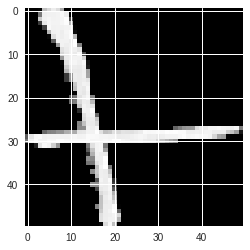

In [30]:
nrows=50
ncols=50
croppedImages=[]
OUTPUTMODE='resize'
#OUTPUTMODE='crop'

for image in Kreuz_Kreis_Plus_images:
    DeltaRows,DeltaCols = 50-image.shape[0],50-image.shape[1]
    if OUTPUTMODE=='resize':
        image_cropped=skimage.transform.resize(image,(nrows,ncols),mode='constant')
    else:
        image_cropped=crop_it_myself(image,DeltaRows,DeltaCols)
    croppedImages.append(image_cropped)

plt.imshow(croppedImages[43],interpolation='none')

Ich finde das Abschneiden weniger hübsch! Allerdings ist mir nicht klar, wie das Bild mit der Funktion "resize()" reskaliert wird. Wie werden Pixelwerte interpoliert? Ich hoffe mal, dass dies keine weitere Rolle spielt. Je nach Anwendung kann sich hier aber eine Einbusse ergeben!

In [0]:
for image in croppedImages:
    assert image.shape==(nrows,ncols),\
    'Spalten und Zeilen sollten nun {0}x{0} sein, sind es aber nicht'.format(
    nrows,ncols)

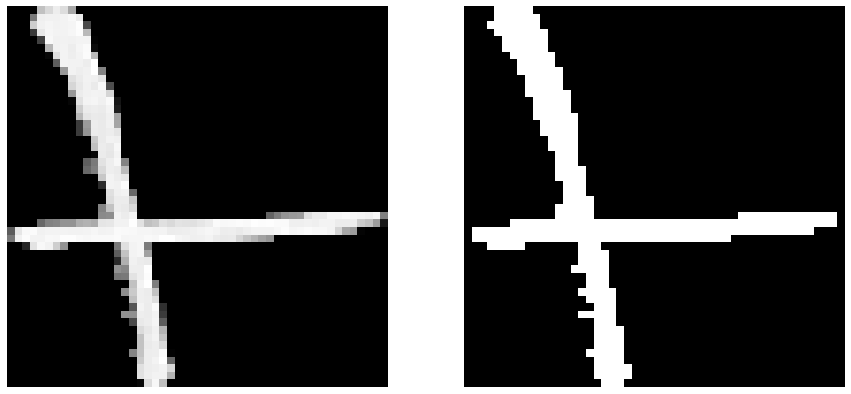

In [32]:
show_images([croppedImages[43],croppedImages[43]>0.5],interpolation='none')

**Aufgabe:**
- Schreiben Sie Ihre Bilder im vorgesehenen Format auf ihre Festplatte.
- Erstellen Sie eine CSV-Datei mit Ziel- und Featurevektor im vorgesehenen Format. 
- Laden Sie beides auf Moodle hoch

Vielleicht helfen Ihnen die folgenden Zellen?

In [62]:
from skimage.io import imsave, imread
import os

os.chdir('/content/gdrive/My Drive/cas_da/')

initialen='pd'
ZUFALLSZEICHENKETTE='pdi'
import os.path

label_dict={}
for iimg,(classLabelChar, image) in enumerate(zip(oxp_labels,croppedImages)):
    basename = '{0}-{1:02}-{2}-{3}.png'.format(classLabelChar,iimg,initialen,ZUFALLSZEICHENKETTE)
    #imsave(basename,image)
    
    

   


  #<Speichern Sie hier ihr 50x50-Graustufenbild ab>

          0         1         2         3         4         5         6   \
0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.754253   
8   0.000000  0.000000  0.000000  0.000000  0.528107  0.813442  0.753873   
9   0.000000  0.000000  0.000000  0.423237  0.799532  0.795932  0.699807   
10  0.000000  0.000000  0.000000  0.776273  0.768340  0.753503  0.000000   
11  0.000000  0.000000  0.605424  0.755126  0.744896  0.185115  0.000000   
12  0.000000

In [63]:
#Hilfsfunktion für den Export in eine CSV-Datei
from skimage.io import imsave, imread
import os

os.chdir('/content/gdrive/My Drive/cas_da/')

import numpy as np
import pandas as pd

def to_binary_csv(X,y,csvfilename,threshold,verbose=False):
    """
    Wende den Schwellwert threshold auf das Grauwertbild X an
    und schreibe alles in eine csv-Datei. 
    Beispiel:
    """
    X=np.array([[0.1,0.9],[0.9,0.0],[0.0,0.0]])
    y=np.array(['x','p','o'])
    to_binary_csv(X,y,'testcsv.csv',0.5)
    """
    wrote CSV file to /tmp/testcsv.csv
    
    Die csv-Datei enthält dann
    x,1,0
    p,0,1
    o,1,1
    """
    with open(csvfilename,'w') as fh:
        for iimg,(image,label) in enumerate(zip(X,y)):
            classLabelChar=y[iimg]
            binaryimage=np.where(image>threshold,0,1)
            line=','.join([classLabelChar]+[str(num) for num in binaryimage.ravel()])+'\n'
            fh.write(line)
    print('wrote CSV file to {0}'.format(csvfilename))
   


data = pd.DataFrame(image)
data




,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.076353,0.052860,0.029367,0.005873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.090235,0.062471,0.034706,0.006941,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.104118,0.072081,0.040045,0.008009,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.118000,0.081692,0.045385,0.009077,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.131882,0.091303,0.050724,0.010145,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000554,0.002768,0.004982,0.007196,...,0.159504,0.118834,0.078164,0.037494,0.025687,0.023501,0.021315,0.019129,0.016943,0.014756
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001661,0.008303,0.014946,0.021588,...,0.200865,0.164285,0.127705,0.091125,0.077061,0.070503,0.063945,0.057386,0.050828,0.044269
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002768,0.013839,0.024909,0.035980,...,0.242226,0.209736,0.177246,0.144756,0.128436,0.117505,0.106574,0.095644,0.084713,0.073782
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003875,0.019374,0.034873,0.050373,...,0.283588,0.255187,0.226787,0.198387,0.179810,0.164507,0.149204,0.133901,0.118598,0.103295
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004982,0.024909,0.044837,0.064765,...,0.324949,0.300639,0.276328,0.252018,0.231184,0.211509,0.191834,0.172158,0.152483,0.132808


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls /content/gdrive/My\ Drive/cas_da